Imports

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


# %load_ext autoreload
#%autoreload 2

In [49]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
clean_df = df.copy()

In [50]:
df.head(3)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


1. Preprocessing / Data Cleaning


In [58]:
troll_df =  df
# troll_df['bmi'] = troll_df['bmi'].fillna(troll_df['bmi'].median())
# troll_df['bmi']
# troll_df = troll_df[troll_df.bmi <= 60]
troll_df.bmi.isna().value_counts()

bmi
False    4909
True      201
Name: count, dtype: int64

In [23]:
if "Other" in clean_df.gender.value_counts():
    clean_df = df[df.gender != 'Other']
    # on va en discuter tkt
    clean_df = clean_df[clean_df.age>30]
    # clean_df = clean_df.dropna(axis=0, subset='bmi')

    # binaires à faire dans la pipeline dans le script bonus
    clean_df.ever_married = clean_df.ever_married.apply(lambda x : 1 if x == "Yes" else 0)
    clean_df.Residence_type = clean_df.Residence_type.apply(lambda x : 1 if x == "Urban" else 0)
    clean_df.gender = clean_df.gender.apply(lambda x : 1 if x == "Female" else 0)



    # from Sacia
    clean_df['bmi'] = clean_df['bmi'].fillna(df['bmi'].median())
    clean_df = clean_df[clean_df.bmi <= 60]

    # A CHANGER ABSOLUMENT
    clean_df.bmi.fillna(0, inplace=True)


clean_df.shape

(3364, 12)

bmi
False    5110
Name: count, dtype: int64

In [6]:
clean_df.head(3)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,0,67.0,0,1,1,Private,1,228.69,36.6,formerly smoked,1
2,31112,0,80.0,0,1,1,Private,0,105.92,32.5,never smoked,1
3,60182,1,49.0,0,0,1,Private,1,171.23,34.4,smokes,1


In [7]:
clean_df.stroke.value_counts(normalize=True)

stroke
0    0.938169
1    0.061831
Name: proportion, dtype: float64

In [10]:
df.smoking_status

0       formerly smoked
1          never smoked
2          never smoked
3                smokes
4          never smoked
             ...       
5105       never smoked
5106       never smoked
5107       never smoked
5108    formerly smoked
5109            Unknown
Name: smoking_status, Length: 5110, dtype: object

<Axes: >

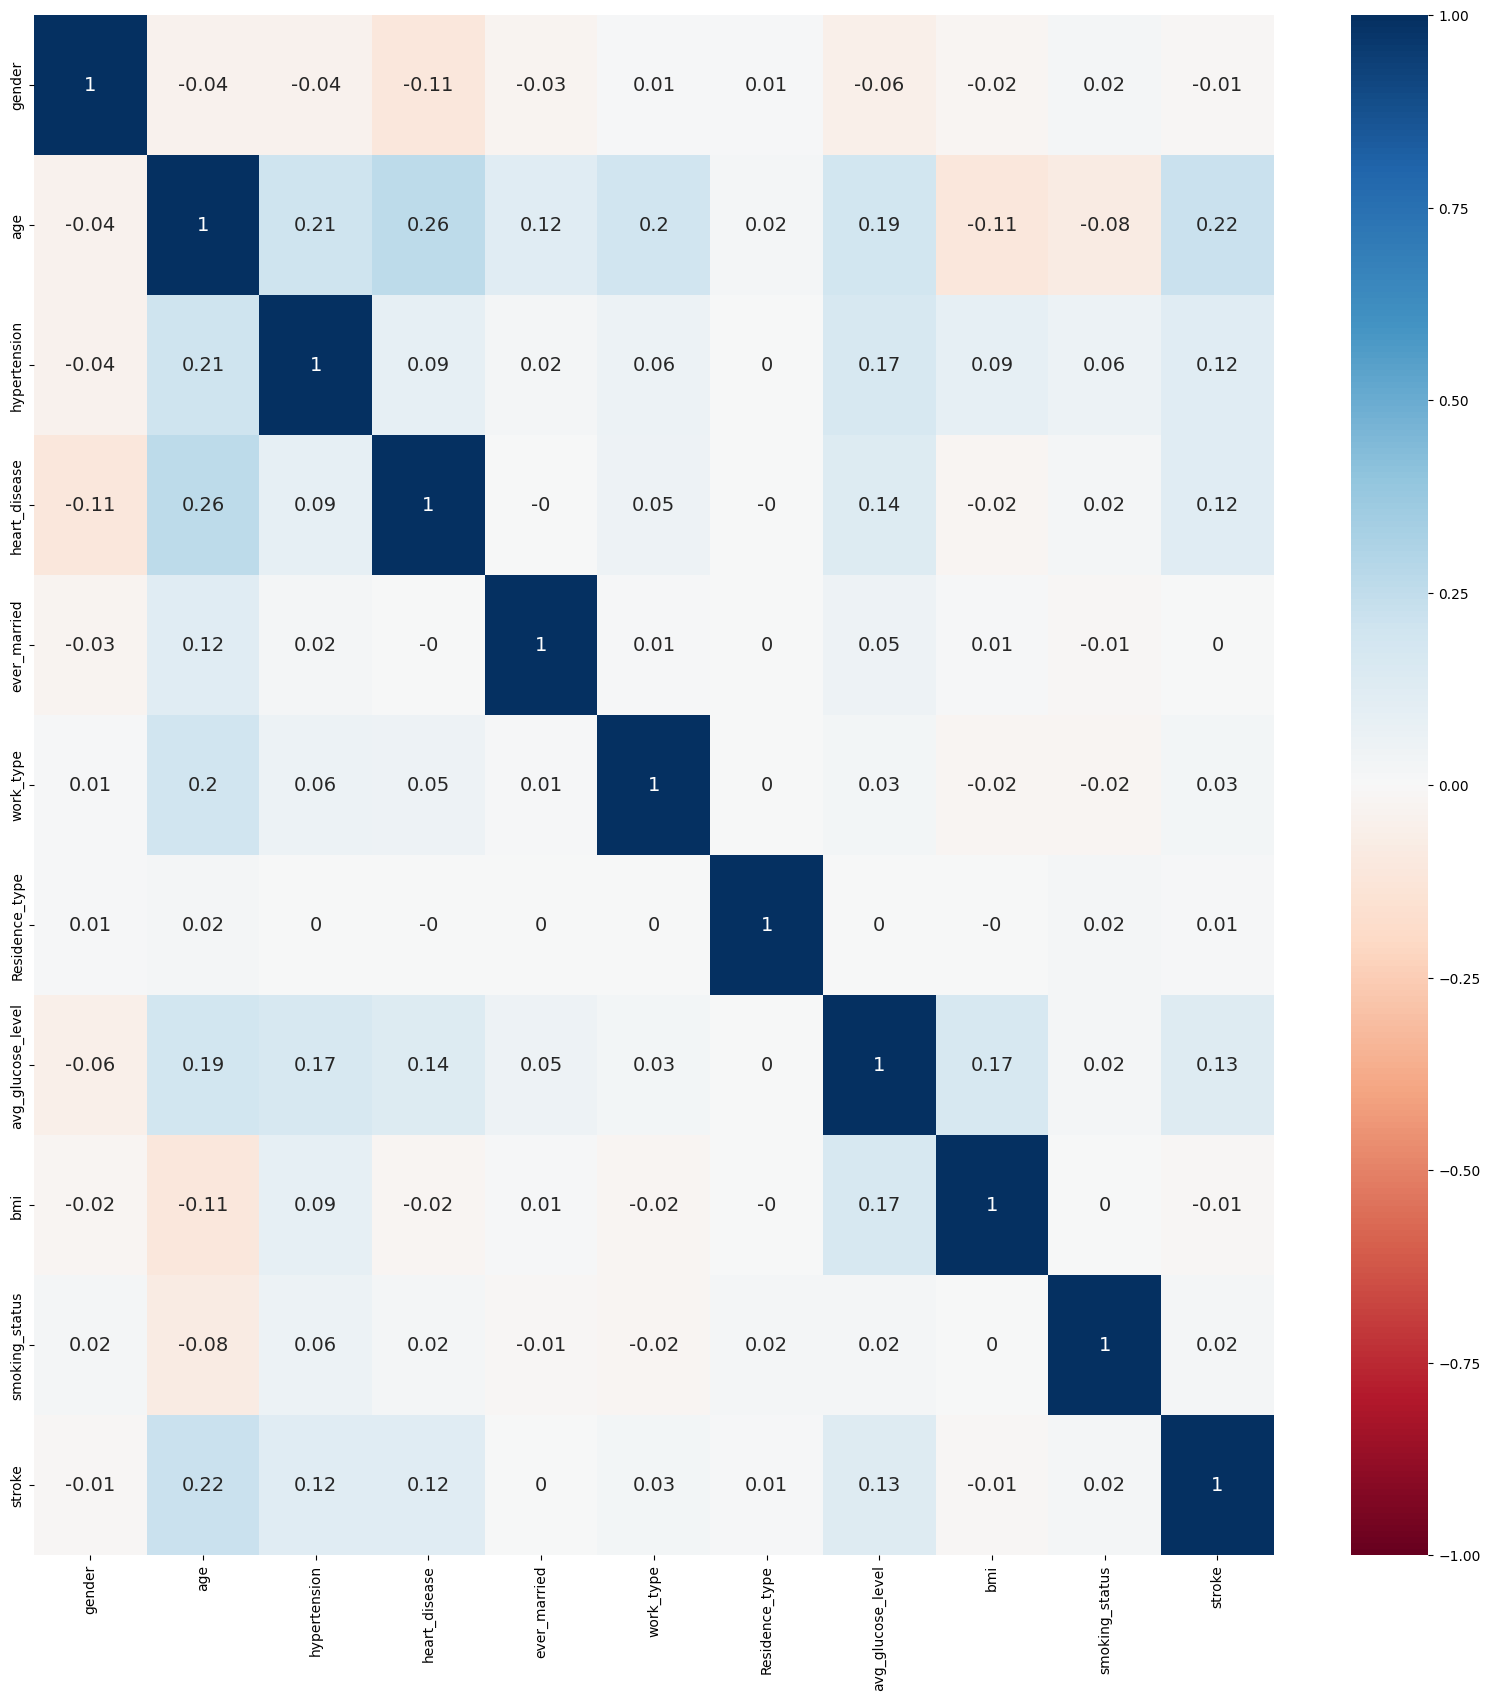

In [9]:
corr_map_df = clean_df.drop(columns='id')
corr_map_df.work_type = corr_map_df['work_type'].astype('category')
corr_map_df.work_type = corr_map_df['work_type'].cat.codes

corr_map_df.smoking_status = corr_map_df['smoking_status'].astype('category')
corr_map_df.smoking_status = corr_map_df['smoking_status'].cat.codes

plt.figure(figsize = (20,20))
sns.heatmap(round(corr_map_df.corr(),2), cmap = "RdBu", annot = True, annot_kws = {"size":14}, vmin =-1, vmax = 1)
# hsv terrain jet rainbow tab10 Pastel1 Set3 RdBu viridis inferno plasma cividis magma

2. Normalisation de la donnée

3. Extraire les informations importantes


A partir de 55 ans, chaque décénie double le risque d'AVC.



D'après :
Rothwell PM, Coull AJ, Silver LE, et al. Population-based study of event-rate, incidence, case fatality, and mortality for all acute vascular events in all arterial territories (Oxford vascular study). Lancet 2005; 366 : 1773–83.

4. La veille 😢😢😢


4.1 La classification supervisée

Décrire le concept lui même puis 3 algos

4.2 1er algorithme de classification supervisée

4.2 2e algorithme de classification supervisée

4.3 3e algorithme de classification supervisée

4.99. La veille est enfin finit ! 🙂🙂🙂

5. Application des trois models précédents sur une seule feature

6. Evaluation des résultats des models et explication du choix de la métrique utilisée

7. Etes-vous satisfait des résultats obtenus ?

Hell nah !

7.5 Ajout de nouvelles features aux model, les justifier.

8. Comparaison avec les résultats précédents.

8.5 Conclusion sur la modélisation la plus efficace pour la prévention des attaques cérébrales.